In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score
from time import time
from scipy.spatial.distance import euclidean
from sklearn.metrics import average_precision_score
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal as multi_norm

### Prepare Reality Mining Data

In [2]:
# Apps By Week
df = pd.read_csv('/Users/tradergllc/rsi/datasets/proc/reality-mining/txt/interim/appsByWeek-clean.txt', 
                 sep=', ', header=None, engine='python', dtype=str, names=['id', 'date', 'app', 'freq'])

In [3]:
df['app'].unique().shape

(206,)

In [4]:
# Clean app names
# for r in range(len(df.index)):
#     if df.iloc[r, 2].find(':') > -1:
#         print df.iloc[r]
#         df.iloc[r, 2] = 'Phone'

In [5]:
df.iloc[5699]

id               21
date         2005.1
app     context_log
freq             26
Name: 5699, dtype: object

In [6]:
def convert_to_dict(df):
    data_dict = {}
    
    unique = list(df.iloc[:, 2].unique())
    
    date_list = [df.iloc[0, 1]]
    pid_date_list = [(df.iloc[0,0], df.iloc[0, 1])]
    
    data_dict[int(df.iloc[0,0])] = {}
    data_dict[int(df.iloc[0,0])][df.iloc[0, 1]] = np.zeros((len(unique),))
    data_dict[int(df.iloc[0,0])][df.iloc[0, 1]][unique.index(df.iloc[0, 2])] = 1
        
    for r in range(1, len(df.index)):
        pid = int(df.iloc[r, 0])
        if pid not in data_dict.keys():
            data_dict[pid] = {}        
        
        if (df.iloc[r, 0], df.iloc[r, 1]) in pid_date_list:
            data_dict[pid][df.iloc[r, 1]][unique.index(df.iloc[r, 2])] = 1 #df.iloc[r, 3]
        else:
            date_list.append(df.iloc[r, 1])
            pid_date_list.append((df.iloc[r, 0], df.iloc[r, 1]))
            
            data_dict[pid][df.iloc[r, 1]] = np.zeros((len(unique),))
            data_dict[pid][df.iloc[r, 1]][unique.index(df.iloc[r, 2])] = 1
                        
    return data_dict, unique

In [7]:
data_dict, unique = convert_to_dict(df)

In [8]:
def dict_to_np_array(d):
    vector_list = []
    gt_pid = []
    for pid in d.keys():
        for date in d[pid].keys():
#             print pid, date
            vector_list.append(d[pid][date])
            gt_pid.append(d.keys().index(pid))
    return np.stack(vector_list), np.array(gt_pid)

In [9]:
x_train_full, y_train = dict_to_np_array(data_dict)
print x_train_full.shape, y_train.shape

(1911, 206) (1911,)


In [10]:
y_train

array([ 0,  0,  0, ..., 87, 87, 87])

In [11]:
x_train_full.shape

(1911, 206)

In [12]:
x_train = x_train_full.copy()

In [13]:
print x_train.shape

(1911, 206)


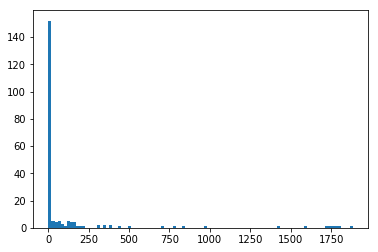

In [14]:
plt.hist(x_train.sum(axis=0), bins=100)
plt.show()

### PCA

In [15]:
pca = PCA(n_components=50)

In [16]:
pca = pca.fit(x_train)

In [17]:
pca.singular_values_

array([39.18479782, 26.19881929, 21.45940745, 20.81112053, 19.25379724,
       18.49135162, 17.96787686, 16.67327746, 16.21671193, 15.90739693,
       15.08561193, 14.78312852, 14.46408608, 13.96809963, 13.35234089,
       12.8332565 , 12.31770188, 12.03810315, 11.75646864, 11.5481956 ,
       11.37792431, 11.2380605 , 11.06304108, 10.91563215, 10.67145308,
       10.30917082, 10.1982052 ,  9.93871312,  9.61499358,  9.30903736,
        9.04508497,  8.60108366,  8.49377209,  8.23558145,  7.98028981,
        7.92960842,  7.78787883,  7.47434344,  7.14779048,  6.88346703,
        6.75484746,  6.62364843,  6.36591595,  6.26641073,  6.13019839,
        6.04872241,  5.9083277 ,  5.83535511,  5.64530192,  5.21908781])

In [18]:
x_transform = pca.transform(x_train)
print x_transform.shape

(1911, 50)


### Apply Generative Probabilistic Model

In [19]:
N_SINGLETONS = 65
N_PAIRS = 5

In [20]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87])

In [21]:
singletons = np.random.choice(range(y_train.max() + 1), N_SINGLETONS, replace=False)
# pairs = np.random.choice( )
print singletons

[15 85 16  5 32 76 43 30 17 67 14 59  2 27 66 65 49 60 41 10 42 12 11 81
  8 48 87 46  6 63 55 53 19 62 70 69 57 33 64 78 82 56 73 47 40 61 83 13
 44 36 75 86 39  4 74 38 80  1 25 52 18 72 71  3 29]


In [22]:
remaining_idx = []
for i in np.arange(y_train.max() + 1):
    if i not in singletons:
        remaining_idx.append(i)
print remaining_idx

[0, 7, 9, 20, 21, 22, 23, 24, 26, 28, 31, 34, 35, 37, 45, 50, 51, 54, 58, 68, 77, 79, 84]


In [23]:
pairs = np.random.choice(remaining_idx, N_PAIRS, replace=False)
print pairs

[35 51 84 34 45]


In [24]:
vec_list = []
labels = []
GT_POS_PAIRS = []

pid_list = data_dict.keys()

for p in range(len(pairs)):
    pid = pid_list[pairs[p]]
#     print pid
    w1, w2 = np.random.choice(data_dict[pid].keys(), 2)
#     print w1, w2
    app_vec1, app_vec2 = data_dict[pid][w1], data_dict[pid][w2]
    
    vec_list.append(app_vec1)
    vec_list.append(app_vec2)
    
    labels.append(p + 1)
    labels.append(p + 1)
    GT_POS_PAIRS.append((2* p, 2* p + 1))

for s in singletons:
    pid = pid_list[s]
    w = np.random.choice(data_dict[pid].keys(), 1)
#     print pid
#     print w
    app_vec = data_dict[pid][w[0]]
    vec_list.append(app_vec)
    labels.append(0)

In [25]:
vec_list = np.array(vec_list)

In [26]:
points = pca.transform(vec_list)
# points = vec_list

In [27]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(points)

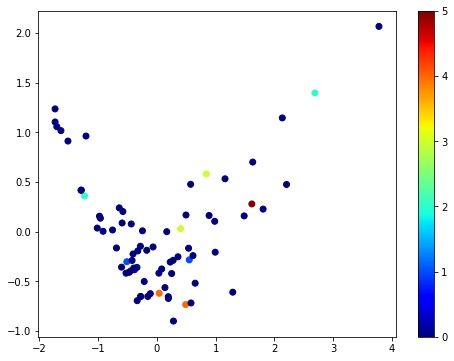

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='jet')
plt.colorbar()
plt.show()

In [29]:
N_DIM = len(points.shape)
test_mean = np.mean(points, axis=0)
print test_mean
sigma = np.std(points)
std_axis = np.std(points, axis=0)
print std_axis
print sigma

[ 0.03588028 -0.00296291  0.0220825   0.0174959  -0.10238589 -0.0089522
 -0.06941473 -0.03505211  0.0228553   0.05069034  0.04333247  0.01827013
  0.00687353 -0.02714038 -0.04533475  0.01213467 -0.00308054 -0.01212196
  0.01249626 -0.01617138 -0.00501801  0.03469869  0.0225561  -0.01973456
  0.02137857  0.01815357  0.08159057 -0.00070999 -0.0290483   0.03757955
 -0.02758023  0.00272084 -0.02688301 -0.0203341  -0.0025873  -0.0336167
  0.01362164  0.01054779  0.00781336 -0.00420975 -0.01562425 -0.02359816
  0.02804386  0.00279926 -0.00727323  0.00791278 -0.00197898  0.02643199
 -0.00195862 -0.00048371]
[1.03445799 0.5824764  0.52606328 0.48005078 0.41596026 0.41058331
 0.33477169 0.35985984 0.31089452 0.39334726 0.32008132 0.30540882
 0.32486871 0.33479279 0.30920283 0.27268286 0.2534041  0.25601788
 0.26787377 0.2626088  0.29286407 0.23454387 0.26812852 0.2610577
 0.28357189 0.24132474 0.27607922 0.2188447  0.22317373 0.18752503
 0.19884131 0.25057792 0.20099693 0.17505419 0.15198312 0.

In [30]:
nu = 0.1

In [31]:
t = (np.ones(std_axis.shape) * nu) / (std_axis + 1e-5)
# dis_var = np.matmul(t.transpose(), cov)

In [32]:
dis_var = np.diag(t)
print dis_var

[[0.09666805 0.         0.         ... 0.         0.         0.        ]
 [0.         0.17167783 0.         ... 0.         0.         0.        ]
 [0.         0.         0.19008759 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.6756054  0.         0.        ]
 [0.         0.         0.         ... 0.         1.02891447 0.        ]
 [0.         0.         0.         ... 0.         0.         0.97037407]]


In [33]:
cov = np.cov(points.transpose())

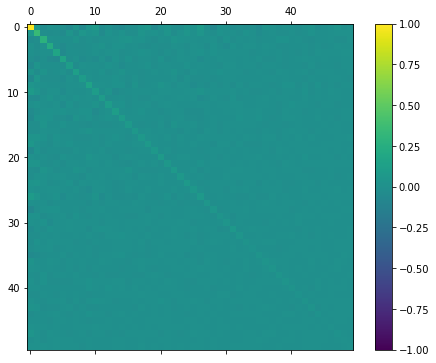

In [34]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
cax = ax.matshow(cov, vmin=-1, vmax=1)
fig.colorbar(cax)
# plt.style.use('grayscale')
plt.show()

In [35]:
start = time()

LR_arr = []
LR_idx = []

dist_matrix = np.zeros((points.shape[0], points.shape[0]))
adj_matrix = np.zeros((points.shape[0], points.shape[0]))

for i in np.arange(points.shape[0]):
    for j in np.arange(i + 1, points.shape[0]):
        midpoint = 0.5 * (points[i] + points[j])
        
        dis = 0.5* (points[i] - points[j])
        pdf_mid = multi_norm.pdf(midpoint, mean=test_mean, cov=cov, allow_singular=True)
        pdf_dis = multi_norm.pdf(dis, mean=np.zeros(dis.shape), cov=dis_var, allow_singular=True)
        pdf_x_i = multi_norm.pdf(points[i], mean=test_mean, cov=cov, allow_singular=True)
        pdf_x_j = multi_norm.pdf(points[j], mean=test_mean, cov=cov, allow_singular=True)
        LR = pdf_mid * pdf_dis / (pdf_x_i*pdf_x_j)
        LR_arr.append(LR)
        dist_matrix[i, j] = LR
        
        if (i, j) in GT_POS_PAIRS:
            LR_idx.append(True)
            adj_matrix[i, j] = 1
        else:
            LR_idx.append(False)
            adj_matrix[i, j] = 0
            
print 'time elapsed: %f s' % (time() - start)

LR_arr = np.array(LR_arr)
LR_idx = np.array(LR_idx)

time elapsed: 6.324865 s


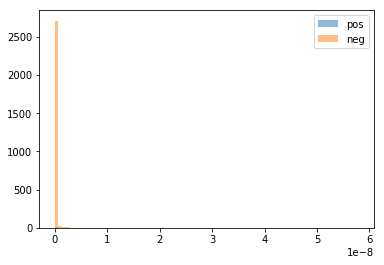

In [36]:
bins = np.linspace(LR_arr.min(), LR_arr.max(), 100)

plt.hist(LR_arr[LR_idx], bins, alpha=0.5, label='pos')
plt.hist(LR_arr[LR_idx == False], bins, alpha=0.5, label='neg')
plt.legend(loc='upper right')
plt.show()

In [37]:
print roc_auc_score(y_true=LR_idx, y_score=LR_arr)

0.3670036101083032
